#### Setup
We first set the notebook to display the output from each code block, <br>
then import the required packages and set the file directory.

In [81]:
from __future__ import print_function
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import tensorflow as tf


try:
    import keras
    from imblearn.keras import balanced_batch_generator
    from imblearn.under_sampling import NearMiss
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Activation
    from keras.optimizers import Adam
    from keras.losses import categorical_crossentropy
    from keras import regularizers

except:
    print("Keras not found")
    
np.random.seed(42)


def my_basename(path):
    return os.path.splitext(os.path.split(path)[1])[0]

file_dir=r'/Users/neeraj/BTP'

A text file is made in which to store the results of model testing.

In [82]:
#create text file to store results in and close again:
with open(file_dir+'/results/DNN_performance/DNN_eval.txt','w+') as file:
    file.write("Species"+"\t"+"Test_loss"+"\t"+"Test_acc"+"\t"+"Test_tpr"+"\t"+"Test_AUC"+"\t"+"Test_LCI95%"+"\t"+"Test_UCI95%"+"\t"+"occ_samples"+"\t"+"abs_samples"+"\n")
    file.close()

93

The species names are loaded in to iterate through during training and testing. <br>
Environmental variable names are stored in a list, to be used for determining feature importance.

In [83]:
#access file with list of taxa names
taxa=pd.read_csv(file_dir+"/data/spec_filtered/taxa.txt",header=None)
taxa.columns=["taxon"] 

###column variable names
with open(file_dir+'/data/GIS/env_stacked/variable_list.txt') as f:
      new_cols = f.readlines()

var_names=[]
for item in new_cols:
    item=item.replace("\n","")
    var_names.append(item) 

#### Model training and testing
For each species in the dataset, the DNN model is trained and tested. <br>
This starts by opening the prepared dataset containing presences, pseudo-absences and associated environmental variable values. This dataframe then needs to be separated into a separate numpy array containing the environmental variable values (X) and presence/pseudo-absence (y). These arrays are further separated into a training (85% of samples) and test subset (15% of samples). Next the model is constructed and the training subset is fed to the model for training model weights. After training the test set is fed to the model and the output metric scores are saved to a text file. <br> The model weights and feature importance of the best performing model across five repeated runs are also saved to file.

In [ ]:
for species in taxa["taxon"][:]:
    
    # open dataframe and rename columns
    spec = species
    table = pd.read_csv(file_dir +"/data/spec_occ_env/%s_env_dataframe.csv"%spec)         
    table.rename(columns=dict(zip(table.columns[1:42], var_names)),inplace=True)

    ####################################
    #  filter dataframe for training   #
    ####################################

    # drop any row with no-data values
    table = table.dropna(axis=0, how="any")

    # make feature vector
    band_columns = [column for column in table.columns[1:42]]
    
    X = []
    y = []

    for _, row in table.iterrows():
        x = row[band_columns].values
        x = x.tolist()
        x.append(row["present/pseudo_absent"])
        X.append(x)

    df = pd.DataFrame(data=X, columns=band_columns + ["presence"])
    df.to_csv("filtered.csv", index=None)
    
    # extract n. of occ. and abs. samples
    occ_len=int(len(df[df["presence" ]==1]))
    abs_len=int(len(df[df["presence" ]==0]))
    
    ####################################
    #  Numpy feature and target array  #
    ####################################

    X = []
    y = []

    band_columns = [column for column in df.columns[:-1]]

    for _, row in df.iterrows():
        X.append(row[band_columns].values.tolist())
        y.append([1 - row["presence"], row["presence"]])

    X = np.vstack(X)
    y = np.vstack(y)

    
    ####################################
    #    Split training and test set   #
    ####################################

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y,random_state=42)
    
    test_set=pd.DataFrame(X_test)
    test_set.rename(columns=dict(zip(test_set.columns[0:40], var_names)),inplace=True)
    
     
    ####################################
    #      Training and testing        #
    ####################################
    
    # prepare metrics
    test_loss=[]
    test_acc=[]
    test_AUC=[]
    test_tpr=[]
    test_uci=[]
    test_lci=[]

    Best_model_AUC=[0]
    
    # Five repetions
    for i in range(1,6): 
        # print("run %s"%i)
        ###################
        # Construct model #
        ###################
        batch_size = 75
        num_classes = 2
        epochs = 125

        num_inputs = X.shape[1]  


        model = Sequential()
        layer_1 = Dense(50, activation='relu',input_shape=(num_inputs,))#, kernel_regularizer=regularizers.l1(0.000001))

        layer_2 = Dense(25, activation='relu', input_shape=(num_inputs,))#, kernel_regularizer=regularizers.l1(0.000001))
        layer_3 = Dense(25, activation='relu', input_shape=(num_inputs,))#, kernel_regularizer=regularizers.l1(0.0000001))
        layer_4 = Dense(25, activation='relu', input_shape=(num_inputs,))#, kernel_regularizer=regularizers.l1(0.00000001))


        model.add(layer_1)
        model.add(Dropout(0.3))
        model.add(layer_2)
        model.add(Dropout(0.5))
        model.add(layer_3)
        model.add(Dropout(0.3))
        model.add(layer_4)
        model.add(Dropout(0.5))


        out_layer = Dense(num_classes, activation=None)
        model.add(out_layer)
        model.add(Activation("softmax"))
        model.summary()
        model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.001), metrics =['accuracy'])
        
        ###############
        # Train model #
        ###############
        training_generator,steps_per_epoch = balanced_batch_generator(X_train, y_train, sampler=NearMiss(), batch_size=75, random_state=42)
        print(training_generator)
        history = model.fit_generator(generator=training_generator, steps_per_epoch=steps_per_epoch, epochs=125, verbose=0)


        ##############
        # Test model #
        ##############
        score = model.evaluate(X_test, y_test, verbose=0)
        predictions = model.predict(X_test)
        fpr, tpr, thresholds = roc_curve(y_test[:, 1], predictions[:, 1])
        len_tpr=int(len(tpr)/2)
        
        #################
        # Append scores #
        #################
        test_loss.append(score[0])
        test_acc.append(score[1])
        test_AUC.append(roc_auc_score(y_test[:, 1], predictions[:, 1]))
        test_tpr.append(tpr[len_tpr])
        AUC = roc_auc_score(y_test[:, 1], predictions[:, 1])

        ###############################
        # Create confidence intervals #
        ###############################
        n_bootstraps=1000
        y_pred=predictions[:,1]
        y_true=y_test[:,1]
        rng_seed=42
        bootstrapped_scores =[]
        
        rng=np.random.RandomState(rng_seed)
        
        for i in range (n_bootstraps):
            # bootstrap by sampling with replacement on prediction indices
            indices = rng.randint(0,len(y_pred)-1,len(y_pred))
            if len (np.unique(y_true[indices])) <2:
                continue
                
            score = roc_auc_score(y_true[indices],y_pred[indices])
            bootstrapped_scores.append(score)

        sorted_scores=np.array(bootstrapped_scores)
        sorted_scores.sort()

        ci_lower=sorted_scores[int(0.05*len(sorted_scores))]
        ci_upper=sorted_scores[int(0.95*len(sorted_scores))]

        test_lci.append(ci_lower)
        test_uci.append(ci_upper)
        
        
        ##############################################################
        # Selection of best model across runs and feature importance #
        ##############################################################

        #determine whether this run's model AUC is higher than previous
        if AUC > Best_model_AUC[0]:
            # if yes save model to disk / overwrite previous model
            Best_model_AUC[0]=AUC
            model_json=model.to_json()
            with open (file_dir+'/results/{}/{}_model.json'.format(spec,spec),'w') as json_file:
                json_file.write(model_json)
            model.save_weights(file_dir+'/results/{}/{}_model.h5'.format(spec,spec))
            #if yes, save a figure of shap feature value impact    
            explainer=shap.DeepExplainer(model,X_train)
            shap_values=explainer.shap_values(X_test)
            fig=shap.summary_plot(shap_values[1],test_set,show=False)
            plt.savefig(file_dir+'/results/{}/{}_feature_impact'.format(spec,spec),bbox_inches="tight")
            plt.close()
            


    # Model output metrics averaged across five runs to be written to file
    avg_loss= sum(test_loss)/len(test_loss)
    avg_acc = sum(test_acc)/len(test_acc)
    avg_AUC = sum(test_AUC)/len(test_AUC)
    avg_tpr = sum(test_tpr)/len(test_tpr)
    avg_lci = sum(test_lci)/len(test_lci)
    avg_uci = sum(test_uci)/len(test_uci)

    # Write to file
    with open(file_dir+'/results/DNN_performance/DNN_eval.txt','a') as file:
        file.write(spec+"\t"+str(avg_loss)+"\t"+str(avg_acc)+"\t"+str(avg_tpr)+"\t"+str(avg_AUC)+"\t"+str(avg_lci)+"\t"+str(avg_uci)+"\t"+str(occ_len)+"\t"+str(abs_len)+"\n")       

    #Next species!

Finally, after having processed all species, graphs with performance metric scores against the number of occurrence samples are created for a visual assessment of overall model performance.

Text(0.5, 0, 'Occurrence samples')

Text(0, 0.5, 'Test loss')

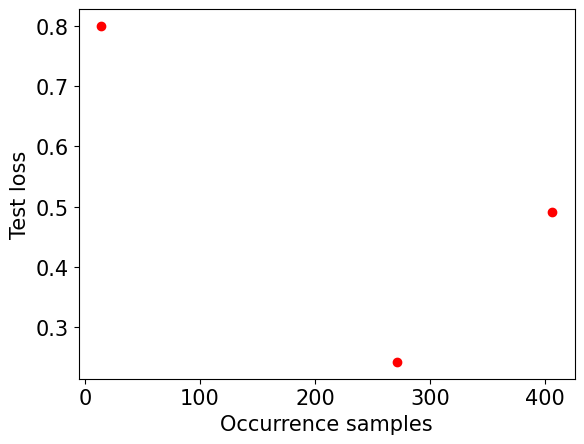

Text(0.5, 0, 'Occurrence samples')

Text(0, 0.5, 'Test accuracy')

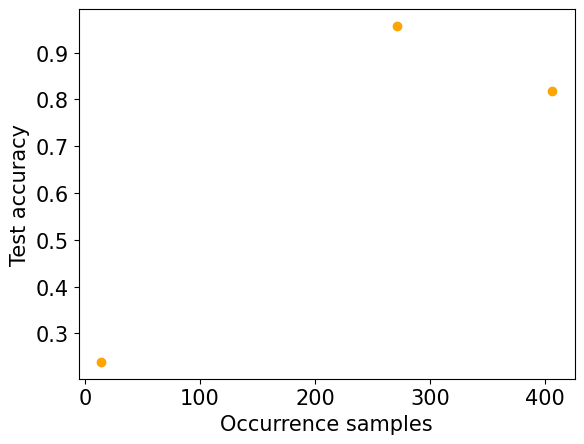

Text(0.5, 0, 'Occurrence samples')

Text(0, 0.5, 'Test AUC')

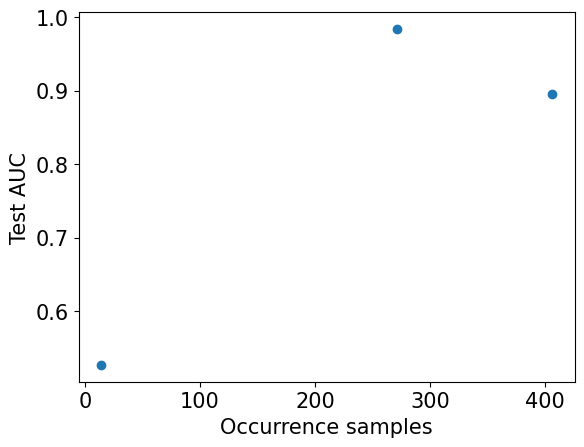

Text(0.5, 0, 'Occurrence samples')

Text(0, 0.5, 'Confidence band width')

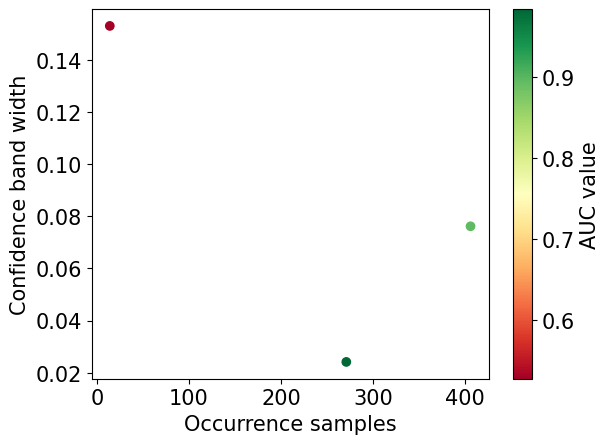

In [87]:
#Open the file with model performance metrics
data=pd.read_csv(file_dir+'/results/DNN_performance/DNN_eval.txt',sep="\t")

#set font size of axis
plt.rcParams.update({'font.size': 15})

#separate the metrics
x=data["occ_samples"]
y1=data["Test_loss"]
y2=data["Test_acc"]
y3=data["Test_AUC"]

lci=data["Test_LCI95%"]
uci=data["Test_UCI95%"]
wci=data["Test_UCI95%"]-data["Test_LCI95%"]


#Plot loss
fig = plt.figure()
plt.scatter(x,y1,c="red")
plt.xlabel("Occurrence samples")
plt.ylabel("Test loss")
fig.savefig(file_dir+'/results/DNN_performance/Test_loss.png', dpi=fig.dpi)
plt.show()

#Plot accuracy
fig = plt.figure()
plt.scatter(x,y2,c="orange")
plt.xlabel("Occurrence samples")
plt.ylabel("Test accuracy")
fig.savefig(file_dir+'/results/DNN_performance/Test_acc.png', dpi=fig.dpi,bbox_inches='tight')
plt.show()

#Plot AUC
fig = plt.figure()
plt.scatter(x,y3)
plt.xlabel("Occurrence samples")
plt.ylabel("Test AUC")
fig.savefig(file_dir+'/results/DNN_performance/Test_AUC.png', dpi=fig.dpi,bbox_inches='tight')
plt.show()

#Plot confidence bands
fig = plt.figure()
points=plt.scatter(x,wci,c=y3,cmap="RdYlGn")
cbar=plt.colorbar(points)
cbar.set_label("AUC value")
plt.xlabel("Occurrence samples")
plt.ylabel("Confidence band width")
fig.savefig(file_dir+'/results/DNN_performance/Confidence_width.png', dpi=fig.dpi,bbox_inches='tight')
plt.show()